<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Astronomy_Uncertainty_Estimation_in_Radiative_Models_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Uncertainty estimation using neural networks

In this notebook, we attempt to emulate the radiative transfer equation using neural networks.


Radiative transfer equation quantifies how the intensity, $I(s)$, changes along a ray,
\begin{equation}
\frac{dI}{ds} \ = \ \eta(s) \ - \ \chi(s) I(s),
\end{equation}
in which $\eta(s)$ is the emissivity and $\chi(s)$ is the opacity. This can be solved given a boundary condition $I_{\text{bdy}}$ at the beginning of the ray.


Usually this is written in terms of the optical depth, defined as
\begin{equation}
    \tau(z,s) \ \equiv \ \int_{z}^{s} ds' \ \chi(s')
\end{equation}
which simplifies the formal solution,

\begin{equation}
    I(s) \ = \ I_{\text{bdy}} e^{-\tau(s_{\text{bdy}},s)} \ + \ \int_{s_{\text{bdy}}}^{s} ds' \ \eta(s') e^{-\tau(s_{\text{bdy}},s')} .
\end{equation}

The aim of this work is to find a neural network to emulate the following function,

\begin{equation}
    \texttt{input} =
    \left(\begin{matrix}
        s    \\
        ds   \\
        \eta \\
        \chi \\
        I_{\text{bdy}}
    \end{matrix}\right)
    \ \longrightarrow \
    \texttt{output} = I
\end{equation}




In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import os
import sys
import urllib.request
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt
from matplotlib import ticker
import h5py as h5
import time
from datetime import datetime
import pandas as pd
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called `sciml-workshop-data`.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, the folder `sciml-workshop-data` will appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Astronomy')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Astronomy/"
files_to_download = ["RTE_train.h5", "RTE_test.h5"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

Our data are stored in the hdf files `Astronomy/RTE_train.h5` and `Astronomy/RTE_test.h5`.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
with h5.File(join(data_path, 'Astronomy/RTE_train.h5'), 'r') as F:
    train_Intensity = np.array(F['Intensity'])
    train_z = np.array(F['z'])
    train_dz = np.array(F['dz'])
    train_eta = np.array(F['eta'])
    train_chi = np.array(F['chi'])
    train_Ibdy = np.array(F['Ibdy'])
    
with h5.File(join(data_path, 'Astronomy/RTE_test.h5'), 'r') as F:
    test_Intensity = np.array(F['Intensity'])
    test_z = np.array(F['z'])
    test_dz = np.array(F['dz'])
    test_eta = np.array(F['eta'])
    test_chi = np.array(F['chi'])
    test_Ibdy = np.array(F['Ibdy'])
```
    
</p>
</details>

In [4]:
with h5.File(join(data_path, 'Astronomy/RTE_train.h5'), 'r') as F:
    train_Intensity = np.array(F['Intensity'])
    train_z = np.array(F['z'])
    train_dz = np.array(F['dz'])
    train_eta = np.array(F['eta'])
    train_chi = np.array(F['chi'])
    train_Ibdy = np.array(F['Ibdy'])

with h5.File(join(data_path, 'Astronomy/RTE_test.h5'), 'r') as F:
    test_Intensity = np.array(F['Intensity'])
    test_z = np.array(F['z'])
    test_dz = np.array(F['dz'])
    test_eta = np.array(F['eta'])
    test_chi = np.array(F['chi'])
    test_Ibdy = np.array(F['Ibdy'])

In [5]:
x_train = np.concatenate((train_z, train_dz, train_eta, train_chi, train_Ibdy), axis = -1)
y_train = np.stack(train_Intensity)

x_test = np.concatenate((test_z, test_dz, test_eta, test_chi, test_Ibdy), axis = -1)
y_test = np.stack(test_Intensity)

print('x train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('x test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)

x train shape:  (10000, 256)
y train shape:  (10000, 1)
x test shape:  (1000, 256)
y test shape:  (1000, 1)


### Calculate the intensity using the formal solution

In [6]:
def solver_approx(eta, chi, dz, I_bdy):
    """
    A "quick-and-dirty" short-characteristics solver.
    """
    # Compute cell-averaged eta and chi
    eta_avg = 0.5*(eta[1:] + eta[:-1])
    chi_avg = 0.5*(chi[1:] + chi[:-1])
    # Approximate optical depth
    tau = np.cumsum(chi_avg*dz)
    # Get target output by approximating the formal solution
    I = I_bdy*np.exp(-tau[-1]) + np.sum(eta_avg*np.exp(-tau)*dz)
    # Return target value
    return I

In [7]:
y_train_approx = []
for i in range(len(y_train)):
    y_train_approx.append(solver_approx (train_eta[i], train_chi[i], train_dz[i], train_Ibdy[i]))

y_test_approx = []
for i in range(len(y_test)):
    y_test_approx.append(solver_approx (test_eta[i], test_chi[i], test_dz[i], test_Ibdy[i]))


y_train_approx = np.stack(y_train_approx)
y_test_approx = np.stack(y_test_approx)

---

# 2. Build the network

We will build a simple linear regression model and a fully-connected neural network to compare their results. The output is continuous values and so we use 'mean squared error loss'.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(256,)))
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
model.add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_1'))
model.add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_2'))
model.add(tf.keras.layers.Dense(1,activation='linear',name='output'))


opt = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=opt,loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
startTime = datetime.now()
history = model.fit(x_train, y_train, epochs=500,batch_size=128,validation_split= 0.2,
                      verbose=2,shuffle=False,callbacks=[early_stopping])
First_Trial = datetime.now() - startTime
print("\nTime taken: ", First_Trial)
```
    
</p>
</details>

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(256,)))
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
model.add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_1'))
model.add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_2'))
model.add(tf.keras.layers.Dense(1,activation='linear',name='output'))


opt = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=opt,loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
startTime = datetime.now()
history = model.fit(x_train, y_train, epochs=500,batch_size=128,validation_split= 0.2,
                      verbose=2,shuffle=False,callbacks=[early_stopping])
First_Trial = datetime.now() - startTime
print("\nTime taken: ", First_Trial)

Epoch 1/500
63/63 - 4s - 57ms/step - loss: 0.2540 - val_loss: 0.0755
Epoch 2/500
63/63 - 1s - 16ms/step - loss: 0.0535 - val_loss: 0.0496
Epoch 3/500
63/63 - 0s - 6ms/step - loss: 0.0388 - val_loss: 0.0366
Epoch 4/500
63/63 - 0s - 5ms/step - loss: 0.0301 - val_loss: 0.0308
Epoch 5/500
63/63 - 0s - 5ms/step - loss: 0.0251 - val_loss: 0.0271
Epoch 6/500
63/63 - 0s - 6ms/step - loss: 0.0217 - val_loss: 0.0237
Epoch 7/500
63/63 - 0s - 5ms/step - loss: 0.0192 - val_loss: 0.0224
Epoch 8/500
63/63 - 0s - 5ms/step - loss: 0.0172 - val_loss: 0.0207
Epoch 9/500
63/63 - 0s - 5ms/step - loss: 0.0155 - val_loss: 0.0186
Epoch 10/500
63/63 - 0s - 5ms/step - loss: 0.0141 - val_loss: 0.0170
Epoch 11/500
63/63 - 0s - 5ms/step - loss: 0.0130 - val_loss: 0.0157
Epoch 12/500
63/63 - 0s - 5ms/step - loss: 0.0121 - val_loss: 0.0147
Epoch 13/500
63/63 - 0s - 5ms/step - loss: 0.0114 - val_loss: 0.0139
Epoch 14/500
63/63 - 0s - 5ms/step - loss: 0.0108 - val_loss: 0.0132
Epoch 15/500
63/63 - 0s - 5ms/step - loss

---

# 3. Analyse results

### Compare approximate intensity and prediction by the model

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(10, 7))

#plot 1:
plt.subplot(2,1,1)
plt.title('Approximate solution from the formal solution on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_test_approx, 'b', label = 'approximate intensity')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor = (1., 1.05))

#plot 2:
plt.subplot(2,1,2)
plt.title('Prediction by neural network on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_pred, 'b', label = 'prediction')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor = (1., 1.05))

```
    
</p>
</details>

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


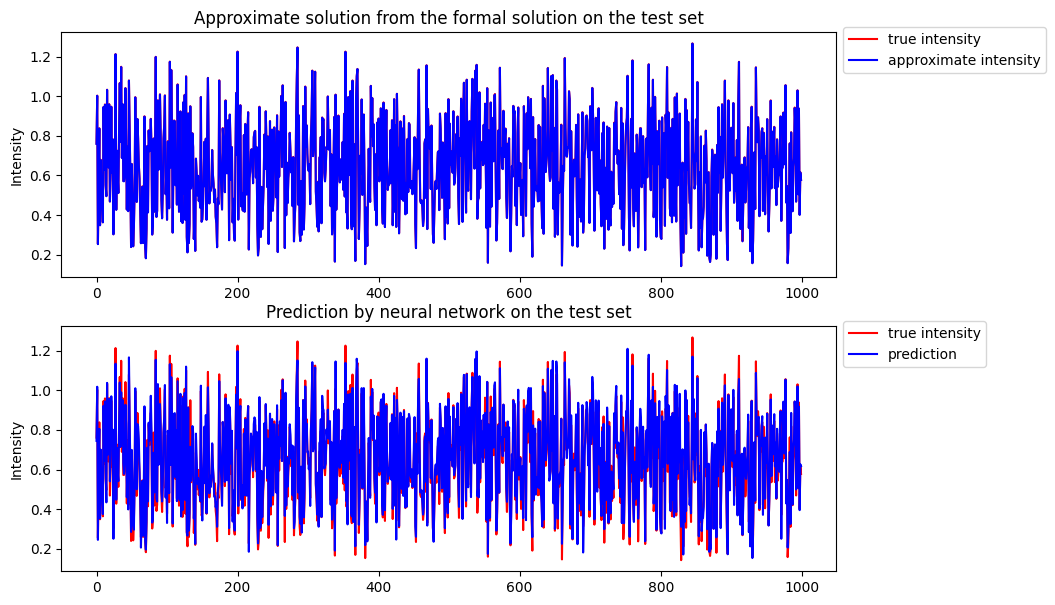

In [9]:
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(10, 7))

#plot 1:
plt.subplot(2,1,1)
plt.title('Approximate solution from the formal solution on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_test_approx, 'b', label = 'approximate intensity')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor = (1., 1.05))

#plot 2:
plt.subplot(2,1,2)
plt.title('Prediction by neural network on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_pred, 'b', label = 'prediction')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor = (1., 1.05))


### Train multiple models for uncertainty of intensity

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

MODELS = {}
HISTORY = {}
for i in range(5):
    opt = tf.keras.optimizers.Adam(0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
    
    MODELS[i] = tf.keras.models.Sequential()
    MODELS[i].add(tf.keras.Input(shape=(256,)))
    MODELS[i].add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_1'))
    MODELS[i].add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_2'))
    # Define output layer
    MODELS[i].add(tf.keras.layers.Dense(1,activation='linear',name='output'))

    MODELS[i].compile(optimizer=opt,loss='mse')
    
    startTime = datetime.now()
    HISTORY[i] = MODELS[i].fit(x_train, y_train, epochs=500,batch_size=128,validation_split= 0.2,
                          verbose=2,shuffle=False,callbacks=[early_stopping])
    First_Trial = datetime.now() - startTime
    print("\nTime taken: ", First_Trial)
```
    
</p>
</details>

In [10]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

MODELS = {}
HISTORY = {}
for i in range(5):
    opt = tf.keras.optimizers.Adam(0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

    MODELS[i] = tf.keras.models.Sequential()
    MODELS[i].add(tf.keras.Input(shape=(256,)))
    MODELS[i].add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_1'))
    MODELS[i].add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_2'))
    # Define output layer
    MODELS[i].add(tf.keras.layers.Dense(1,activation='linear',name='output'))

    MODELS[i].compile(optimizer=opt,loss='mse')

    startTime = datetime.now()
    HISTORY[i] = MODELS[i].fit(x_train, y_train, epochs=500,batch_size=128,validation_split= 0.2,
                          verbose=2,shuffle=False,callbacks=[early_stopping])
    First_Trial = datetime.now() - startTime
    print("\nTime taken: ", First_Trial)

Epoch 1/500
63/63 - 2s - 34ms/step - loss: 0.4941 - val_loss: 0.0997
Epoch 2/500
63/63 - 1s - 13ms/step - loss: 0.0758 - val_loss: 0.0640
Epoch 3/500
63/63 - 0s - 5ms/step - loss: 0.0519 - val_loss: 0.0468
Epoch 4/500
63/63 - 0s - 5ms/step - loss: 0.0406 - val_loss: 0.0368
Epoch 5/500
63/63 - 0s - 5ms/step - loss: 0.0334 - val_loss: 0.0312
Epoch 6/500
63/63 - 0s - 5ms/step - loss: 0.0286 - val_loss: 0.0278
Epoch 7/500
63/63 - 0s - 5ms/step - loss: 0.0249 - val_loss: 0.0251
Epoch 8/500
63/63 - 0s - 5ms/step - loss: 0.0220 - val_loss: 0.0227
Epoch 9/500
63/63 - 0s - 5ms/step - loss: 0.0195 - val_loss: 0.0209
Epoch 10/500
63/63 - 0s - 5ms/step - loss: 0.0175 - val_loss: 0.0195
Epoch 11/500
63/63 - 0s - 5ms/step - loss: 0.0161 - val_loss: 0.0184
Epoch 12/500
63/63 - 0s - 5ms/step - loss: 0.0149 - val_loss: 0.0175
Epoch 13/500
63/63 - 0s - 5ms/step - loss: 0.0139 - val_loss: 0.0167
Epoch 14/500
63/63 - 0s - 5ms/step - loss: 0.0131 - val_loss: 0.0160
Epoch 15/500
63/63 - 0s - 5ms/step - loss

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


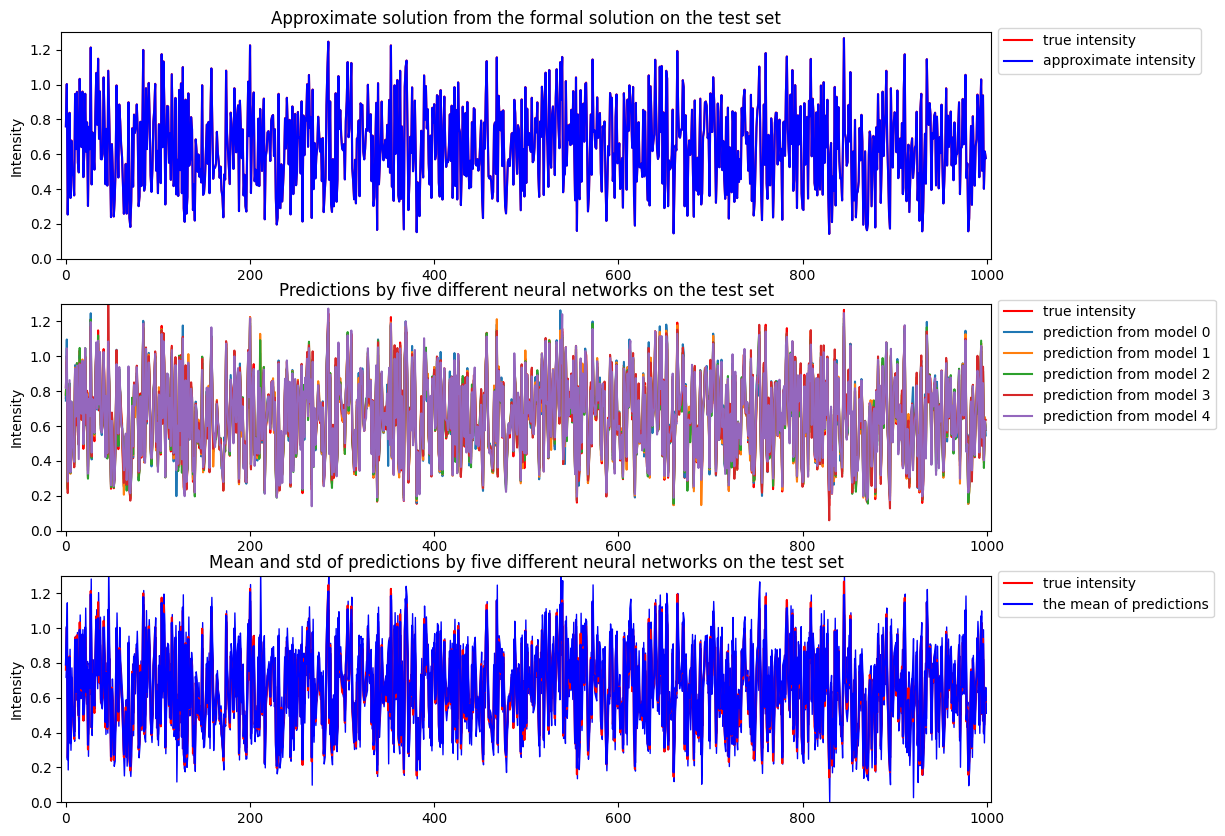

In [11]:
confidence_level = 2.57
TEST_PREDS = []
for i in range(5):
    TEST_PREDS.append(MODELS[i].predict(x_test))

test_mean = np.mean(np.concatenate(TEST_PREDS, axis = -1), axis = -1)
test_std = np.std(np.concatenate(TEST_PREDS, axis = -1), axis = -1)


#plot 1:
plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
plt.title('Approximate solution from the formal solution on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_test_approx, 'b', label = 'approximate intensity')
plt.ylabel('Intensity')
plt.axis([-5, 1005, 0, 1.3])
plt.legend(bbox_to_anchor = (1., 1.05))

#plot 2:
plt.subplot(3, 1, 2)
plt.title('Predictions by five different neural networks on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
for i in range(5):
    plt.plot(np.arange(len(y_test)), TEST_PREDS[i], label = 'prediction from model {}'.format(i))
plt.ylabel('Intensity')
plt.axis([-5, 1005, 0, 1.3])
plt.legend(bbox_to_anchor = (1., 1.05))


#plot 3:
plt.subplot(3, 1, 3)
plt.title('Mean and std of predictions by five different neural networks on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), test_mean, 'b', label = 'the mean of predictions')
plt.fill_between(np.arange(len(test_mean)), (test_mean-confidence_level*test_std).reshape(-1), (test_mean+confidence_level*test_std).reshape(-1),color='blue', alpha=1.0)
plt.ylabel('Intensity')
plt.axis([-5, 1005, 0, 1.3])
plt.legend(bbox_to_anchor = (1., 1.05))

---

# 4. Exercises

* Train more models and compare the results
* Compute uncertainty using other machine learning methods such as Gaussian process or Bayesian approcaches and compare the results